In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', None)

from tensorflow.keras.preprocessing import text, sequence
from tensorflow import keras
from keras.utils import np_utils

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/baochi0212/data-science-e10.git

Cloning into 'data-science-e10'...
remote: Enumerating objects: 5634, done.
remote: Counting objects: 100% (847/847), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 5634 (delta 625), reused 831 (delta 619), pack-reused 4787
Receiving objects: 100% (5634/5634), 30.73 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (2210/2210), done.


In [3]:
%cd /kaggle/working/data-science-e10/data/processed/modelling

/kaggle/working/data-science-e10/data/processed/modelling


In [4]:
train_df = pd.read_json('sensitive_train.json')
test_df = pd.read_json('sensitive_test.json')

In [5]:
train_df.head()

,text,label
0,Mayorga said that ahead of El Salvador’s legis...,politics
1,"Citing unnamed sources, The Associated Press r...",politics
2,"Instead, she said, Bukele came to meet with th...",politics
3,Mayorga said Bukele’s government didn’t say an...,politics
4,Animosity between the two appears to have star...,politics


In [6]:
test_df.head()

,text,label
0,"ET, saying that the GOP failed to show that an...",politics
1,"Despite potential safety concerns, Gates has b...",politics
2,The word cheating also trended on Twitter on t...,politics
3,The worker is seen telling voters to place the...,politics
4,Both Lake and Ward have espoused baseless clai...,politics


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1532 non-null   object
 1   label   1532 non-null   object
dtypes: object(2)
memory usage: 24.1+ KB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1019 non-null   object
 1   label   1019 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


In [9]:
train_df.isna().sum()

text     0
label    0
dtype: int64

In [10]:
test_df.isna().sum()

text     0
label    0
dtype: int64

# EDA

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train_df.text.values, train_df.label.values,
                                                  stratify=train_df.label.values,
                                                  test_size=.1, shuffle=True, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1378,), (154,), (1378,), (154,))

In [12]:
X_test = test_df.text.values
y_test = test_df.label.values

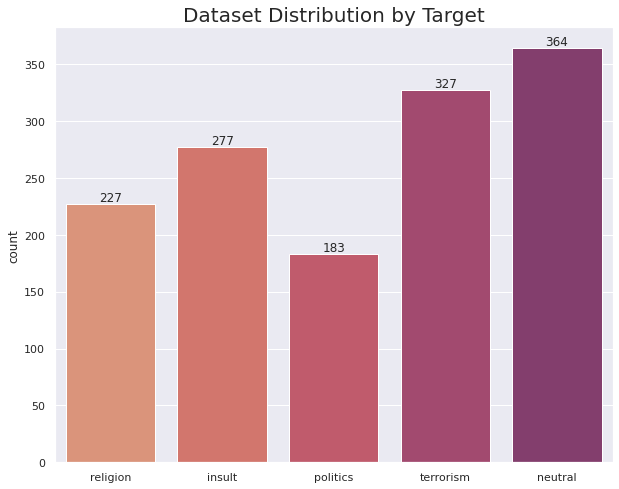

In [13]:
sns.set_theme(palette="flare")

plt.subplots(figsize=(10, 8))
ax = sns.countplot(y_train)
ax.bar_label(ax.containers[0])
plt.title('Dataset Distribution by Target', fontsize=20)
plt.show()

In [14]:
text_len = np.array([len(tweet.split(' ')) for tweet in X_train])

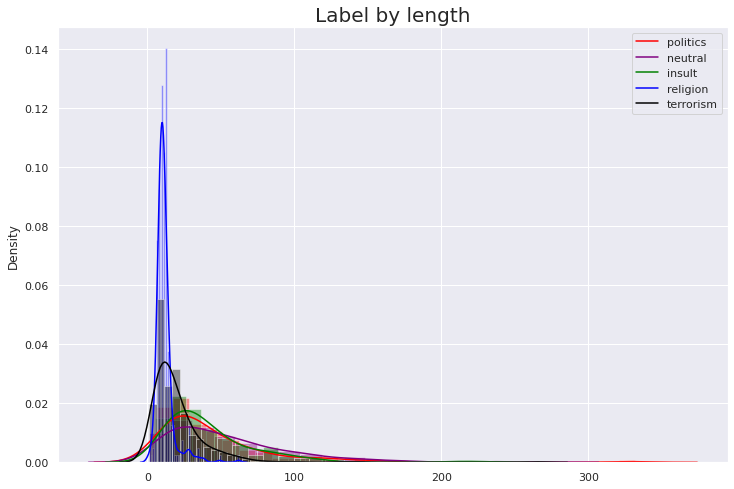

In [15]:
plt.subplots(figsize=(12,8))
sns.distplot(text_len[(y_train == 'religion')], color='r')
sns.distplot(text_len[(y_train == 'insult')], color='purple')
sns.distplot(text_len[(y_train == 'politics')], color='g')
sns.distplot(text_len[(y_train == 'terrorism')], color='blue')
sns.distplot(text_len[y_train == 'neutral'], color='black')
plt.legend(['politics', 'neutral', 'insult', 'religion', 'terrorism'])
plt.title('Label by length', fontsize=20)
plt.show()

# Text Cleaning

In [16]:
X_train

array(['Sorry for misinforming *So in summation, to be clear, since religious people report having an interest in stopping abuse and violence (and since I and many others would certainly prefer that religious people not lie and slander LGBTQ+ people as groomers and perverts and advocate that we be executed) religions and religious people should therefore stop slandering us as groomers and advocating that we be executed and instead begin trying to mitigate the untold damage and abuse on a mass scale caused by institutions they affiliate with, abuses which include thousands and thousands of actua cases of violence and grooming, which were covered up and denied and ignored for as long as possible . . . . .',
       'Excuse me kind sir/madam, what does lopsided mean She had a stroke (or 2! What part of you is tiny Probably his coc Forehead?  Nope Teeth? Nope Eyebrows? Nop Must be the brain Her future via GIPH Lma via GIPH 💀💀 Lmaoo Getting a little old to be stuffing your br Thats where she

In [17]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = str(text).lower()
    text = remove_emoji(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\[', '', text)
    text = re.sub(r'\]', '', text)
    text = re.sub('â\\x92', "'", text)
    text = re.sub('â\S+', '', text)
    text = re.sub('\.+', '.', text)
    text = re.sub('&amp;', 'and', text)
    text = re.sub("let's", 'let us', text)
    text = re.sub("'s", ' is', text)
    text = re.sub("'re", ' are', text)
    text = re.sub("ain't", 'am not', text)
    text = re.sub("won't", 'will not', text)
    text = re.sub("n't", ' not', text)
    text = re.sub("'ve", ' have', text)
    text = re.sub("y'all", "you all", text)
    text = re.sub("'ll", ' will', text)
    text = re.sub("i'd", 'i would', text)
    text = re.sub("i'm", 'i am', text)
    text = re.sub(r"[^a-z<>!?\s]+", '', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [18]:
X_train_clean = np.array([clean_text(text) for text in X_train], dtype='O')
X_val_clean = np.array([clean_text(text) for text in X_val], dtype='O')
X_test_clean = np.array([clean_text(text) for text in X_test], dtype='O')

In [19]:
X_train_clean

array(['sorry for misinforming so in summation to be clear since religious people report having an interest in stopping abuse and violence and since i and many others would certainly prefer that religious people not lie and slander lgbtq people as groomers and perverts and advocate that we be executed religions and religious people should therefore stop slandering us as groomers and advocating that we be executed and instead begin trying to mitigate the untold damage and abuse on a mass scale caused by institutions they affiliate with abuses which include thousands and thousands of actua cases of violence and grooming which were covered up and denied and ignored for as long as possible ',
       'excuse me kind sirmadam what does lopsided mean she had a stroke or ! what part of you is tiny probably his coc forehead? nope teeth? nope eyebrows? nop must be the brain her future via giph lma via giph lmaoo getting a little old to be stuffing your br thats where she keeps the rest of her fo

# Text Preprocessing

## Lemmatization and Stop Words

In [20]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
tokenizer = nltk.tokenize.TweetTokenizer()
def lemmatize(sentence):
    words = tokenizer.tokenize(sentence)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return words

In [21]:
X_train_clean = np.array([lemmatize(text) for text in tqdm(X_train_clean)], dtype='O')
print('LEMMATIZE TRAIN DONE!')
X_val_clean = np.array([lemmatize(text) for text in tqdm(X_val_clean)], dtype='O')
print('LEMMATIZE VAL DONE!')
X_test_clean = np.array([lemmatize(text) for text in tqdm(X_test_clean)], dtype='O')
print('LEMMATIZE TEST DONE!')

100%|██████████| 1378/1378 [00:08<00:00, 168.50it/s]


LEMMATIZE TRAIN DONE!


100%|██████████| 154/154 [00:00<00:00, 192.62it/s]


LEMMATIZE VAL DONE!


100%|██████████| 1019/1019 [00:04<00:00, 238.43it/s]

LEMMATIZE TEST DONE!


In [22]:
X_train_clean

array([list(['sorry', 'misinforming', 'summation', 'clear', 'since', 'religious', 'people', 'report', 'interest', 'stopping', 'abuse', 'violence', 'since', 'many', 'others', 'would', 'certainly', 'prefer', 'religious', 'people', 'lie', 'slander', 'lgbtq', 'people', 'groomers', 'pervert', 'advocate', 'executed', 'religion', 'religious', 'people', 'therefore', 'stop', 'slandering', 'u', 'groomers', 'advocating', 'executed', 'instead', 'begin', 'trying', 'mitigate', 'untold', 'damage', 'abuse', 'mass', 'scale', 'caused', 'institution', 'affiliate', 'abuse', 'include', 'thousand', 'thousand', 'actua', 'case', 'violence', 'grooming', 'covered', 'denied', 'ignored', 'long', 'possible']),
       list(['excuse', 'kind', 'sirmadam', 'lopsided', 'mean', 'stroke', '!', 'part', 'tiny', 'probably', 'coc', 'forehead', '?', 'nope', 'teeth', '?', 'nope', 'eyebrow', '?', 'nop', 'must', 'brain', 'future', 'via', 'giph', 'lma', 'via', 'giph', 'lmaoo', 'getting', 'little', 'old', 'stuffing', 'br', 'thats'

## Word Embedding GloVe

In [23]:
# open glove 840b 300d
from tqdm import tqdm
embedding_index = dict()
with open('/kaggle/input/glovetwitter27b100dtxt/glove.twitter.27B.200d.txt', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f'Found {len(embedding_index)} word vectors')

1193514it [00:58, 20368.11it/s]

Found 1193514 word vectors


In [24]:
max_len = max([len(sent) for sent in X_train_clean])
max_len

193

In [25]:
model_tokenizer = text.Tokenizer(filters=None, oov_token='<OOV>')
model_tokenizer.fit_on_texts(list(X_train_clean) + list(X_val_clean))
X_train_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_train_clean),
                                       maxlen=max_len, padding='post')
X_val_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_val_clean),
                                       maxlen=max_len, padding='post')
X_test_ready = sequence.pad_sequences(model_tokenizer.texts_to_sequences(X_test_clean),
                                       maxlen=max_len, padding='post')

word_index = model_tokenizer.word_index

In [26]:
embedding_matrix = np.zeros((len(word_index) + 1, 200))
for word, i in tqdm(word_index.items()):
    vector = embedding_index.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

100%|██████████| 7114/7114 [00:00<00:00, 253326.19it/s]


In [27]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.015537  ,  0.11158   , -0.23599   , ..., -0.037577  ,
        -0.13539   ,  0.45965001],
       ...,
       [-0.49004   , -0.25727999,  0.6498    , ...,  0.062024  ,
         0.1097    , -0.052649  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.15668   ,  0.53610998, -0.31000999, ...,  0.22171   ,
        -0.39763001, -0.2078    ]])

In [28]:
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
y_train_onehot = onehot.fit_transform(y_train.reshape(-1,1)).toarray()
y_val_onehot = onehot.transform(y_val.reshape(-1,1)).toarray()
y_test_onehot = onehot.transform(y_test.reshape(-1,1)).toarray()

# Modelling

## Fnet


In [29]:
BATCH_SIZE = 512
EPOCHS = 80
MAX_SEQUENCE_LENGTH = 512
VOCAB_SIZE = 15000

EMBED_DIM = 128
INTERMEDIATE_DIM = 512

In [30]:
!pip install keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 kB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 38.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 68.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 52.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 45.1 MB/s eta 0:00:0000:0100:01
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 72.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
import keras_nlp

In [32]:
input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")

x = keras_nlp.layers.TokenAndPositionEmbedding(
                            vocabulary_size=VOCAB_SIZE,
                            sequence_length=MAX_SEQUENCE_LENGTH,
                            embedding_dim=EMBED_DIM,
                            mask_zero=True,
)(input_ids)

x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)
x = keras_nlp.layers.FNetEncoder(intermediate_dim=INTERMEDIATE_DIM)(inputs=x)

x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(5, activation="sigmoid")(x)

fnet_classifier = keras.Model(input_ids, outputs, name="fnet_classifier")

2023-02-12 09:15:17.794700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 09:15:17.795714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 09:15:17.998906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 09:15:17.999952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-12 09:15:18.000817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [33]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


fnet_classifier.summary()
fnet_classifier.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['acc',f1_m,precision_m, recall_m],
)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                   restore_best_weights=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1,
                                              factor=.1)
fnet_classifier.fit(X_train_ready, y_train_onehot, validation_data=(X_val_ready, y_val_onehot), epochs = 120, batch_size=512)

Model: "fnet_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, None)]            0         
_________________________________________________________________
token_and_position_embedding (None, None, 128)         1985536   
_________________________________________________________________
f_net_encoder (FNetEncoder)  (None, None, 128)         132224    
_________________________________________________________________
f_net_encoder_1 (FNetEncoder (None, None, 128)         132224    
_________________________________________________________________
f_net_encoder_2 (FNetEncoder (None, None, 128)         132224    
_________________________________________________________________
f_net_encoder_3 (FNetEncoder (None, None, 128)         132224    
_________________________________________________________________
f_net_encoder_4 (FNetEncoder (None, None, 128)     

2023-02-12 09:15:23.056964: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


3/3 [==============================] - 8s 641ms/step - loss: 0.5682 - acc: 0.2380 - f1_m: 0.1076 - precision_m: 0.0781 - recall_m: 0.1732 - val_loss: 0.5350 - val_acc: 0.2338 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/120
3/3 [==============================] - 1s 326ms/step - loss: 0.5319 - acc: 0.2518 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.5162 - val_acc: 0.2662 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/120
3/3 [==============================] - 1s 327ms/step - loss: 0.5100 - acc: 0.2758 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4997 - val_acc: 0.2662 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/120
3/3 [==============================] - 1s 328ms/step - loss: 0.4989 - acc: 0.2598 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.4986 - val_

In [34]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = fnet_classifier.evaluate(X_test_ready, y_test_onehot, verbose=0)
loss, accuracy, f1_score, precision, recall 

(0.7132572531700134,
 0.5397448539733887,
 0.42156723141670227,
 0.6171290874481201,
 0.32732927799224854)